In [1]:
import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy import optimize

In [2]:
def f(x,y):
    return(x**2+y**2)

In [45]:
def g(x, theta, d=0.01) :
    return f(x.x+d*np.cos(theta), x.y+d*np.sin(theta))
def dg(x, theta, d=0.01):
    return (-d*np.sin(theta)*autograd.grad(f,0)(x.x+d*np.cos(theta),x.y+d*np.sin(theta)) + d*np.cos(theta)*autograd.grad(f,1)(x.x+d*np.cos(theta),x.y+d*np.sin(theta)))

True


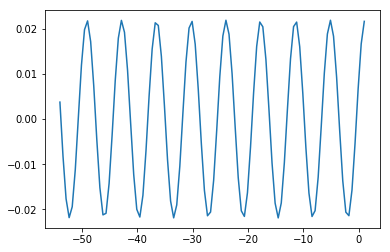

In [102]:
X=np.linspace(-54.,1.,100)
Y=[dg(pt(-1.0,0.4472135975956917), x) for x in X]
plt.plot(X,Y)
print(0.01 >= 0.01)

In [5]:
class pt:
    def __init__(self,x=0.0,y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return('{'+str(self.x)+','+str(self.y)+'}')
        
    def __mul__(a,b):
        if isinstance(b,int) or isinstance(b,float):
            return pt(a.x*b,a.y*b)
        else:
            return pt(a.x*b.x,a.y*b.y)
            
    def __rmul__(a,b):
        if isinstance(a,int) or isinstance(a,float):
            return pt(a*b.x,a*b.y)
        else:
            return a*b
    def __neg__(self):
        return pt(-self.x,-self.y)
        
    def __add__(a,b):
        return pt(a.x+b.x,a.y+b.y)  
    
    def __inv__(self):
        return pt(1/self.x,1/self.y)
    
    def __div__(self,b):
        return (self * (1/b))
    
    def __rdiv__(b,self):
        return pt(self.x/b,self.y/b)
    
    def norme(self):
        return (self.x**2 + self.y**2)**0.5

    def normalized(self):
        return(self*(1/(self.norme())))
        
    def __sub__(self,b):
        return self+ (-b)
        
    def orth(self):
        return pt(-self.y,self.x)

def list_x_y(p):
    x,y = [],[]
    for i in p:
        x.append(i.x)
        y.append(i.y)
    return(np.array(x),np.array(y))
    
def dist(a,b):
    return (a-b).norme()
    
def ingrid(p,grid):
    return(grid[0]<=p.x<=grid[1] and grid[2]<=p.y<=grid[3])

def grad(f,p=pt()):
    g = autograd.grad
    t = np.r_[g(f,0)(p.x,p.y),g(f,1)(p.x,p.y)]
    return pt(t[0],t[1])

In [6]:
def p_a1(ang):
    """
    Cette fonction calcule le point p sur le cercle unite tel que l'angle oriente (pt(1,0),p) vale ang
    """
    return(pt(np.cos(ang),np.sin(ang)))    

def rad(p):
    """
    Cette fonction calcule l'angle oriente (pt(1,0),p)
    """
    x = p.x
    y = p.y
    if abs(x)>abs(y):
        if y >= 0:
            return(np.arccos(x))
        else:
            return(-np.arccos(x))
    else:
        if x >= 0:
            return(np.arcsin(y))
        else:
            return(np.pi-np.arcsin(y))
    
def theta(p0,p):
    """
    calcule l'angle oriente (p0+pt(delta,0),p) ou delta = dist(p0,p)
    """
    de = dist(p0,p)
    return(rad((1/de)*(p-p0)))

def p_a(p0,th,delta):
    """
    calcule le point p tel que dist(p,p0) = delta et theta(p0,p) = th
    """
    p = delta*p_a1(th)
    return(p0+p)

In [7]:
def find_seed(g,c=0,eps=2**(-26)):
    if (g(0)-c)*(g(1)-c) > 0:
        return None
    else:
        a = 0
        b = 1
        while b-a > eps:
            m = (a+b)/2
            if (g(m)-c)*(g(a)-c)<=0:
                b = m
            else:
                a = m
        t = (a+b)/2
        return t

In [153]:
def suivant(f, ad, d, delta, grid):
    h=grad(f,d[0])
    p11 = d[0] + (h.normalized().orth() * delta)
    p12 = d[0] - (h.normalized().orth() * delta)   #on utilise le gradient pour aller au prochain point  
    p1=pt()                                               #mais sans sortir de la grille

    if dist(ad[0], p11)> dist(ad[0], p12):
        if ingrid(p11,grid):
            p1=p11
        else:
            print("p11 est plus loin", "p11", p11, "p12",p12)
            raise ValueError("on boucle")
    else:
        if ingrid(p12,grid):
            p1=p12
        else:
            print("p12 est plus loin", "p11", p11, "p12",p12)
            raise ValueError("on boucle")
    prochain=theta(d[0],p1)
    return((p1,prochain))

In [88]:
def newton(r, ad, d, delta, c):
    derivee=dg(r, d[1],delta)                                  
    if abs(derivee) < 10**(-26):
        print("la dérivée est trop petite")
        return (d[0],d[1])                 
    else:
        return (p_a(r, d[1]-(g(r, d[1],delta) - c)/derivee, delta),d[1]-(g(r,d[1],delta) - c)/derivee)

In [172]:
def simple_contourtrois(f,c=0.0,delta=0.01,grid=[0.,1.,0.,1.],cote=lambda x:f(grid[0],x)):
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt(grid[0],find_seed(cote,c))
    g0 = grad(f,p=p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)

    p1 = pt()
    
    if ingrid(p11,grid):
        p1 = p11
    elif ingrid(p12,grid):
        p1 = p12
    else:
        return [],[]
    
    t1=theta(p0,p1) #pi --> point    ti --> angle
    
    p2, t2 = newton(p1, [p0,0.], [p1, t1], delta, c)
    
    pa = p0 #avant-avant dernier point calculé
    ta = 0.
    pb = p1 #avant-dernier
    tb = t1
    pc = p2 #dernier point calculé
    tc = t2

    pts=[p0, p1]
    ref=p1
  #  if dist(pc,pb)>10**(-12):
      #  pts = [pa]
      #  tc=theta(p1,p2)

  #  else:
      #  pts=[pa,pb]
      #  tc=0.
      #  ref=pb

    try :
        while dist(pc,pa) >= delta/2 and len(pts)<100:
        
            pb, tb = newton(ref, [pc,tc], [pa,ta], delta, c)
            pc, tc = newton(ref, [pa,ta], [pb,tb], delta, c)

            while dist(pc,pb)>10**(-5):
                pa = pb    
                ta = tb
                pb = pc
                tb = tc
                pc, tc = newton(ref, [pa,ta], [pb,tb], delta, c)  #on cherche le nouveau point à partir du dernier
                print("pc",pc)
                print(ingrid(pc,grid))
            
            if not ingrid(pc,grid):
                return list_x_y(pts)
            else:
                pts.append(pc)
                ref = pc
            
                pd = pts[-1]
                td = theta(pts[-2],pd)
                pa, ta = suivant(f, [pd,td], [pc,tc], delta, grid) #on change de point
 
    except ValueError as e:
        print(e)
    print(len(pts))
    return list_x_y(pts)

pc {-1.0,7.45058059692e-09}
False


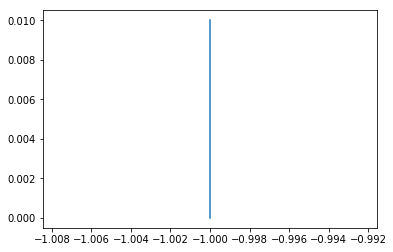

In [173]:
plt.axis('equal')
grid1=[-1.,1.,-1.,1.]
s = simple_contourtrois(f, c=1.0,grid=grid1, cote=lambda x:f(grid1[0],x))
plt.plot(s[0],s[1])

In [174]:
print(ingrid(pt(-1.0,7.45058059692e-09), [-1.,1.,-1.,1.]))

True


In [12]:
def simple_contourdeux(f,c=0.0,delta=0.01,grid=[0.,1.,0.,1.],cote=lambda x:f(0.,x)):
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt(grid[0],t)
    g0 = grad(f,p=p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)
    p1 = pt()
    
    if ingrid(p11,grid):
        p1 = p11
    elif ingrid(p12,grid):
        p1 = p12
    else:
        return [],[]
    t1=theta(p0,p1)    #pi --> point    ti --> angle
    pts=[p0,p1]
    while len(pts)<100000:
        t1 = scipy.optimize.newton(g, t1, fprime=dg)
        p1 = p_a(p1, t1, delta)
        if not ingrid(p1,grid):
            return list_x_y(pts)
        else:
            pts.append(p1)
        p1, t1 = suivant(f, [p1,t1], delta, grid) #on change de point
    return list_x_y(pts)

0.01
0.01
{-0.996083475731,0.456418351132} 4.27359925298


C:\Users\top\Anaconda3\lib\site-packages\scipy\optimize\zeros.py:142: RuntimeWarning: derivative was zero.
  warnings.warn(msg, RuntimeWarning)


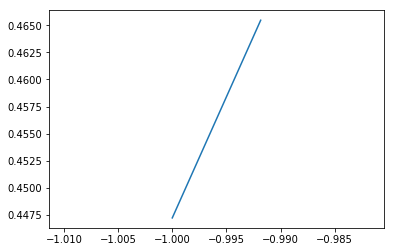

In [19]:
plt.axis('equal')
grid1=[-1.,1.,-1.,1.]
s = simple_contourdeux(f, c=1.2,grid=grid1, cote=lambda x:f(grid1[0],x))
plt.plot(s[0],s[1])